## Tratamento dos dados

### Importando bibliotecas

In [7]:
import numpy as np
from sklearn.metrics import adjusted_rand_score
import pandas as pd
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import pairwise_distances

### Carregando o dataset

In [8]:
def gerar_configuracao(mu_list, sigma_list, tamanhos, config_id):
    dfs = []
    for i, (mu, sigma2, n) in enumerate(zip(mu_list, sigma_list, tamanhos)):
        Sigma = np.diag(sigma2)
        data = np.random.multivariate_normal(mu, Sigma, n)
        df = pd.DataFrame(data, columns=["x1", "x2"])
        df["class"] = i + 1
        dfs.append(df)
    df_config = pd.concat(dfs, ignore_index=True)
    df_config["config"] = config_id
    return df_config

np.random.seed(42)  # reprodutibilidade

# -------------------------------
# Configuração 1
mu_1 = [[5, 0], [15, 5], [18, 14]]
sigma2_1 = [[81, 9], [9, 100], [25, 36]]
n1 = [200, 100, 50]
df1 = gerar_configuracao(mu_1, sigma2_1, n1, config_id=1)
l1 = "Classes elípticas de tamanhos diferentes"

# -------------------------------
# Configuração 2
mu_2 = [[0, 0], [30, 0], [12, 25]]
sigma2_2 = [[100, 100], [49, 49], [16, 16]]
n2 = [200, 100, 50]
df2 = gerar_configuracao(mu_2, sigma2_2, n2, config_id=2)
l2 = "Classes esféricas de tamanhos diferentes"

# -------------------------------
# Configuração 3
mu_3 = [[0, 0], [15, 5], [15, -5]]
sigma2_3 = [[100, 4], [100, 4], [100, 4]]
n3 = [100, 100, 100]
df3 = gerar_configuracao(mu_3, sigma2_3, n3, config_id=3)
l3 = "Classes elípticas de tamanhos iguais"

# -------------------------------
# Configuração 4
mu_4 = [[0, 0], [15, 0], [-15, 0]]
sigma2_4 = [[16, 16], [16, 16], [16, 16]]
n4 = [100, 100, 100]
df4 = gerar_configuracao(mu_4, sigma2_4, n4, config_id=4)
l4 = "Classes elípticas de tamanhos iguais"

# -------------------------------
# Configuração 5
mu_5 = [[5, 0], [15, 5], [10, -7], [3, 15]]
sigma2_5 = [[81, 9], [9, 100], [49, 16], [25, 25]]
n5 = [50, 50, 50, 50]
df5 = gerar_configuracao(mu_5, sigma2_5, n5, config_id=5)
l5 = "3 classes elípticas e 1 esférica"

# -------------------------------
# Configuração 6
mu_6 = [[5, 0], [15, 5], [12, -12], [7, 17]]
sigma2_6 = [[81, 9], [9, 100], [16, 16], [25, 25]]
n6 = [50, 50, 50, 50]
df6 = gerar_configuracao(mu_6, sigma2_6, n6, config_id=6)
l6 = "2 classes elípticas e 2 esféricas"

# -------------------------------
# Configuração 7
mu_7 = [[0, 0], [18, 0], [-18, 0], [0, -12]]
sigma2_7 = [[12, 12], [20, 20], [16, 16], [81, 20]]
n7 = [50, 50, 50, 50]
df7 = gerar_configuracao(mu_7, sigma2_7, n7, config_id=7)
l7 = "1 classe elíptica e 3 esféricas"

### Método

In [9]:
def init_membership_matrix(n, k):
    membership_matrix = np.random.rand(n, k) # gera uma matriz inicial aleatória com valores entre 0 e 1
    membership_matrix = membership_matrix / membership_matrix.sum(axis=1, keepdims=True) # normalização da matriz pra garantir que a soma dos graus dê um
    return membership_matrix

def init_medoids(X, c):
    n = X.shape[0]
    indices = np.random.choice(n, c, replace=False)
    return X[indices]

def update_membership_matrix(data, medoids, m):
    distance_matrix = pairwise_distances(data, medoids, metric='euclidean') ** 2
    distance_matrix = np.fmax(distance_matrix, np.finfo(np.float64).eps)  # evita que matriz_distancias seja 0, np.finfo... é o menor número maior que zero aqui
    
    inverse_distance_matrix = 1 / distance_matrix
    power = 1 / (m - 1)
    updated_membership_matrix = (inverse_distance_matrix ** power) / np.sum(inverse_distance_matrix ** power, axis=1, keepdims=True) # fórmula para atualizar os graus de pertinência
    
    return updated_membership_matrix

def update_medoids(X, membership_matrix, m=2):
    n, c = X.shape[0], membership_matrix.shape[1]
    distances = pairwise_distances(X, X)
    updated_medoids_indices = []

    for i in range(c):  # para cada cluster
        # custo ponderado total para cada possível medoide j
        costs = np.array([
            np.sum((membership_matrix[:, i] ** m) * distances[j, :])
            for j in range(n)
        ])

        # seleciona o ponto com menor custo como novo medoide
        best_medoid_idx = np.argmin(costs)
        updated_medoids_indices.append(best_medoid_idx)

    return X[updated_medoids_indices]

def fcmdd(data, k, m=2, max_iter=1000000):
    n = data.shape[0]
    membership_matrix = init_membership_matrix(n, k)
    medoids = init_medoids(data, k)
    for _ in range(max_iter):
        membership_matrix = update_membership_matrix(data, medoids, m)
        new_medoids = update_medoids(data, membership_matrix, m)
        if np.array_equal(medoids, new_medoids): # se os medoides não mudaram, para
            break
        medoids = new_medoids
    return medoids, membership_matrix

def indice_rand(labels, predicted_labels):
    return adjusted_rand_score(labels, predicted_labels)

def monte_carlo_fuzzy_simulation(X, true_labels, k, m=2, num_trials=100):
    results = []
    for trial in range(num_trials):
        medoids, membership_matrix = fcmdd(X, k, m)
        predicted_labels = np.argmax(membership_matrix, axis=1)
        rand_idx = indice_rand(true_labels, predicted_labels)
        results.append(rand_idx)
    
    mean_ari = np.mean(results)
    std_ari = np.std(results)
    return mean_ari, std_ari

In [48]:
i = 1
for df in [df1, df2, df3, df4, df5, df6, df7]:
    if i == 5 or i == 6 or i == 7:
        num_clusters = 4
    else:
        num_clusters = 3
    df.drop("config", axis=1, inplace=True)
    if i == 5 or i == 6 or i == 7:
        df["class"].replace({1: 0, 2: 1, 3: 2, 4: 3}, inplace=True)
    else: 
        df["class"].replace({1: 0, 2: 1, 3: 2}, inplace=True)
    labels = df["class"].values
    df.drop("class", axis=1, inplace=True)
    data = df.to_numpy()
    k = num_clusters
    num_trials = 100
    m = 2
    mean_rand_index, std_rand_index = monte_carlo_fuzzy_simulation(data, labels, k, m, num_trials)

    print(f"Monte Carlo FCMdd Clustering Results for Config {i}")
    print(f"Mean Rand Index: {mean_rand_index:.3f}")
    print(f"Standard Deviation of Rand Index: {std_rand_index:.3f}")
    print("\n")
    i += 1

Monte Carlo FCMdd Clustering Results for Config 1
Mean Rand Index: 0.278
Standard Deviation of Rand Index: 0.036


Monte Carlo FCMdd Clustering Results for Config 2
Mean Rand Index: 0.602
Standard Deviation of Rand Index: 0.126


Monte Carlo FCMdd Clustering Results for Config 3
Mean Rand Index: 0.211
Standard Deviation of Rand Index: 0.095


Monte Carlo FCMdd Clustering Results for Config 4
Mean Rand Index: 0.806
Standard Deviation of Rand Index: 0.043


Monte Carlo FCMdd Clustering Results for Config 5
Mean Rand Index: 0.378
Standard Deviation of Rand Index: 0.072


Monte Carlo FCMdd Clustering Results for Config 6
Mean Rand Index: 0.404
Standard Deviation of Rand Index: 0.070


Monte Carlo FCMdd Clustering Results for Config 7
Mean Rand Index: 0.629
Standard Deviation of Rand Index: 0.130




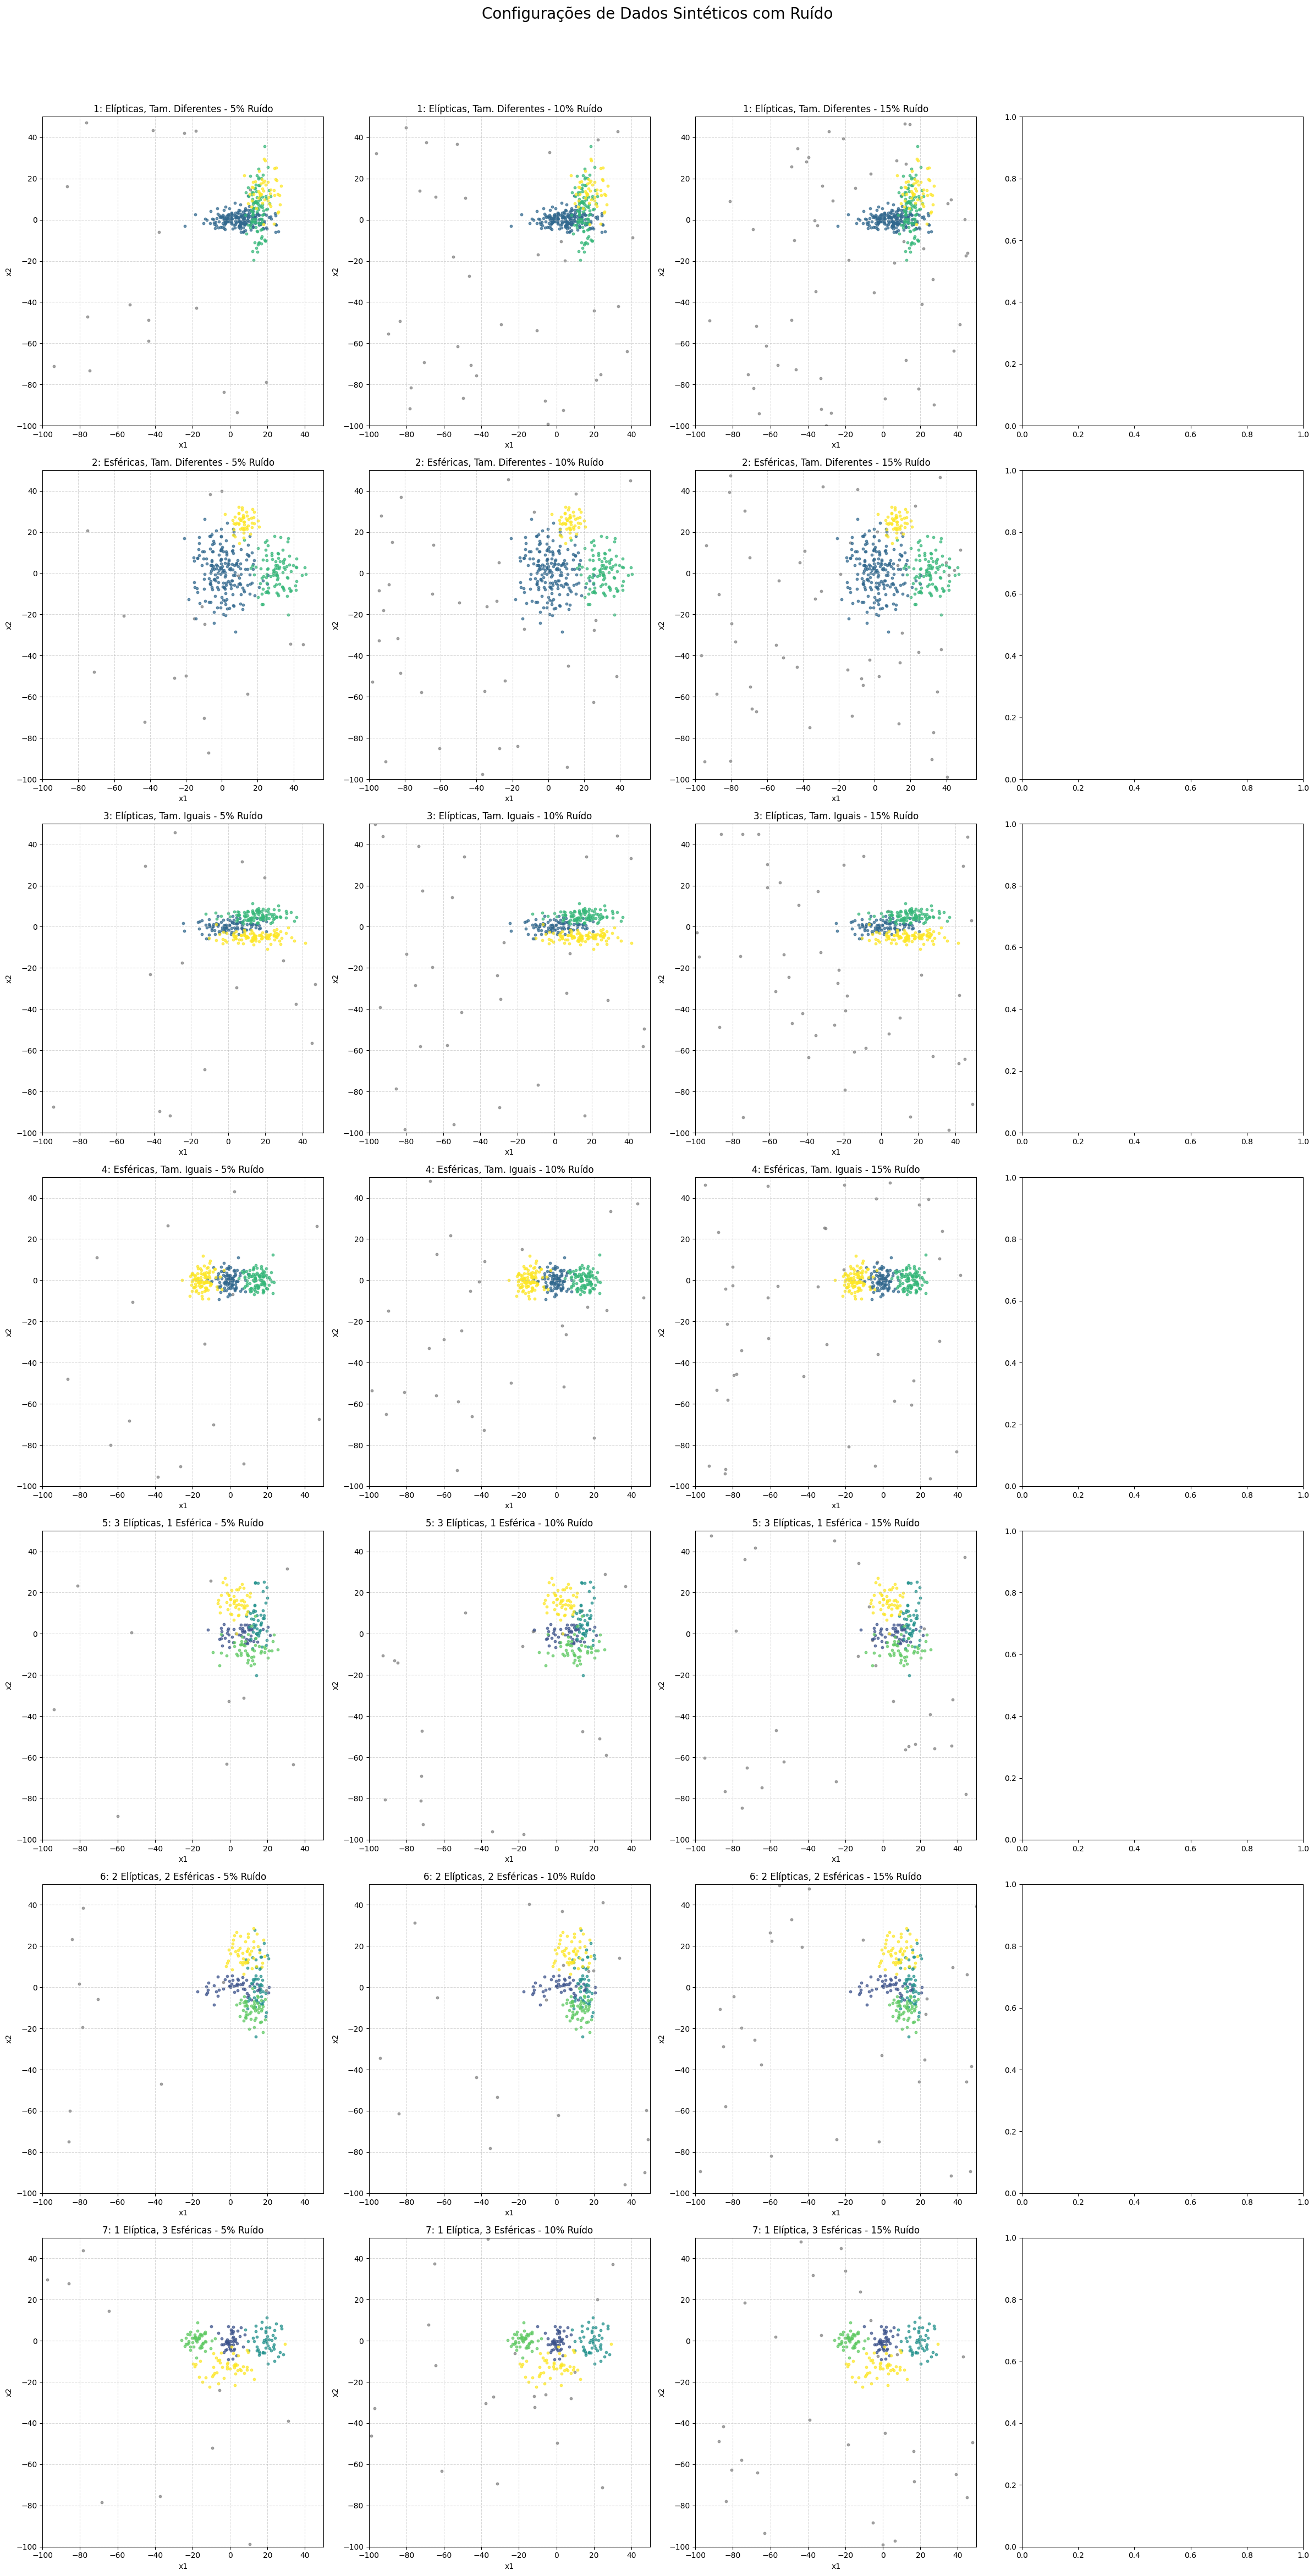

------------------------------
Configuração: 1, Ruído: 5%
Mean Rand Index: 0.261
Standard Deviation of Rand Index: 0.040
------------------------------
Configuração: 1, Ruído: 10%
Mean Rand Index: 0.255
Standard Deviation of Rand Index: 0.041
------------------------------
Configuração: 1, Ruído: 15%
Mean Rand Index: 0.245
Standard Deviation of Rand Index: 0.053
------------------------------
Configuração: 2, Ruído: 5%
Mean Rand Index: 0.540
Standard Deviation of Rand Index: 0.127
------------------------------
Configuração: 2, Ruído: 10%
Mean Rand Index: 0.464
Standard Deviation of Rand Index: 0.105
------------------------------
Configuração: 2, Ruído: 15%
Mean Rand Index: 0.452
Standard Deviation of Rand Index: 0.097
------------------------------
Configuração: 3, Ruído: 5%
Mean Rand Index: 0.191
Standard Deviation of Rand Index: 0.078
------------------------------
Configuração: 3, Ruído: 10%
Mean Rand Index: 0.177
Standard Deviation of Rand Index: 0.053
---------------------------

In [5]:
def gerar_configuracao(mu_list, sigma_list, tamanhos, config_id):
    dfs = []
    for i, (mu, sigma2, n) in enumerate(zip(mu_list, sigma_list, tamanhos)):
        Sigma = np.diag(sigma2)
        data = np.random.multivariate_normal(mu, Sigma, n)
        df = pd.DataFrame(data, columns=["x1", "x2"])
        df["class"] = i + 1
        dfs.append(df)
    df_config = pd.concat(dfs, ignore_index=True)
    df_config["config"] = config_id
    return df_config

def adicionar_ruido(df_original, porcentagem, min_val, max_val):
    n_original = len(df_original)
    n_ruido = int(n_original * porcentagem)

    df_com_ruido = df_original.copy()

    if n_ruido == 0:
        return df_com_ruido

    ruido_x1 = np.random.uniform(min_val, max_val, n_ruido)
    ruido_x2 = np.random.uniform(min_val, max_val, n_ruido)

    df_ruido = pd.DataFrame({'x1': ruido_x1, 'x2': ruido_x2})
    df_ruido['class'] = 0 # Classe 0 para ruído
    df_ruido['config'] = df_original['config'].iloc[0]

    return pd.concat([df_com_ruido, df_ruido], ignore_index=True)

np.random.seed(42)

config_params = [
    {'mu': [[5, 0], [15, 5], [18, 14]], 'sigma2': [[81, 9], [9, 100], [25, 36]], 'n': [200, 100, 50], 'desc': "1: Elípticas, Tam. Diferentes"},
    {'mu': [[0, 0], [30, 0], [12, 25]], 'sigma2': [[100, 100], [49, 49], [16, 16]], 'n': [200, 100, 50], 'desc': "2: Esféricas, Tam. Diferentes"},
    {'mu': [[0, 0], [15, 5], [15, -5]], 'sigma2': [[100, 4], [100, 4], [100, 4]], 'n': [100, 100, 100], 'desc': "3: Elípticas, Tam. Iguais"},
    {'mu': [[0, 0], [15, 0], [-15, 0]], 'sigma2': [[16, 16], [16, 16], [16, 16]], 'n': [100, 100, 100], 'desc': "4: Esféricas, Tam. Iguais"},
    {'mu': [[5, 0], [15, 5], [10, -7], [3, 15]], 'sigma2': [[81, 9], [9, 100], [49, 16], [25, 25]], 'n': [50, 50, 50, 50], 'desc': "5: 3 Elípticas, 1 Esférica"},
    {'mu': [[5, 0], [15, 5], [12, -12], [7, 17]], 'sigma2': [[81, 9], [9, 100], [16, 16], [25, 25]], 'n': [50, 50, 50, 50], 'desc': "6: 2 Elípticas, 2 Esféricas"},
    {'mu': [[0, 0], [18, 0], [-18, 0], [0, -12]], 'sigma2': [[12, 12], [20, 20], [16, 16], [81, 20]], 'n': [50, 50, 50, 50], 'desc': "7: 1 Elíptica, 3 Esféricas"}
]

dados_base = {}
for i, params in enumerate(config_params):
    config_id = i + 1
    dados_base[config_id] = gerar_configuracao(params['mu'], params['sigma2'], params['n'], config_id=config_id)

porcentagens_ruido = [0.05, 0.10, 0.15]
ruido_min, ruido_max = -100, 50
dados_gerados = {}

fig, axes = plt.subplots(7, 4, figsize=(24, 48))
fig.suptitle('Configurações de Dados Sintéticos com Ruído', fontsize=20, y=1.005)

for i, params in enumerate(config_params):
    config_id = i + 1
    df_base_original = dados_base[config_id] 
    dados_gerados[config_id] = {}

    for j, p_ruido in enumerate(porcentagens_ruido):
        p_ruido_int = int(p_ruido * 100)
        df_ruidoso = adicionar_ruido(df_base_original, p_ruido, ruido_min, ruido_max)
        dados_gerados[config_id][p_ruido_int] = df_ruidoso

        ax = axes[i, j]
        cores = plt.cm.viridis(np.linspace(0, 1, len(df_ruidoso['class'].unique())))
        cor_map = {cls: cores[k] for k, cls in enumerate(sorted(df_ruidoso['class'].unique()))}
        cor_map[0] = 'gray'

        for cls in sorted(df_ruidoso['class'].unique()):
            df_subset = df_ruidoso[df_ruidoso['class'] == cls]
            ax.scatter(df_subset['x1'], df_subset['x2'],
                       label=f'Classe {cls}' if cls != 0 else 'Ruído',
                       color=cor_map[cls], s=10, alpha=0.7)

        x_min_data = df_base_original['x1'].min() - 10
        x_max_data = df_base_original['x1'].max() + 10
        y_min_data = df_base_original['x2'].min() - 10
        y_max_data = df_base_original['x2'].max() + 10
        ax.set_xlim(min(ruido_min, x_min_data), max(ruido_max, x_max_data))
        ax.set_ylim(min(ruido_min, y_min_data), max(ruido_max, y_max_data))
        ax.set_title(f"{params['desc']} - {p_ruido_int}% Ruído")
        ax.set_xlabel("x1")
        ax.set_ylabel("x2")
        ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

for config in range(1, 8):
    for noise in [5,10,15]:
        df = dados_gerados[config][noise].copy()
        
        if "config" in df.columns:
            df.drop("config", axis=1, inplace=True) 
        
        labels = df["class"].values
        num_clusters = len(df[df['class'] != 0]['class'].unique())
        
        if "class" in df.columns:
            df.drop("class", axis=1, inplace=True)
            
        dados = df.to_numpy()
        num_trials = 100
        
        media_indice_rand, dp_indice_rand = monte_carlo_fuzzy_simulation(dados, labels, num_clusters)
        print("-" * 30)
        print(f"Configuração: {config}, Ruído: {noise}%")
        print(f"Mean Rand Index: {media_indice_rand:.3f}")
        print(f"Standard Deviation of Rand Index: {dp_indice_rand:.3f}")

In [10]:
np.random.seed(42)

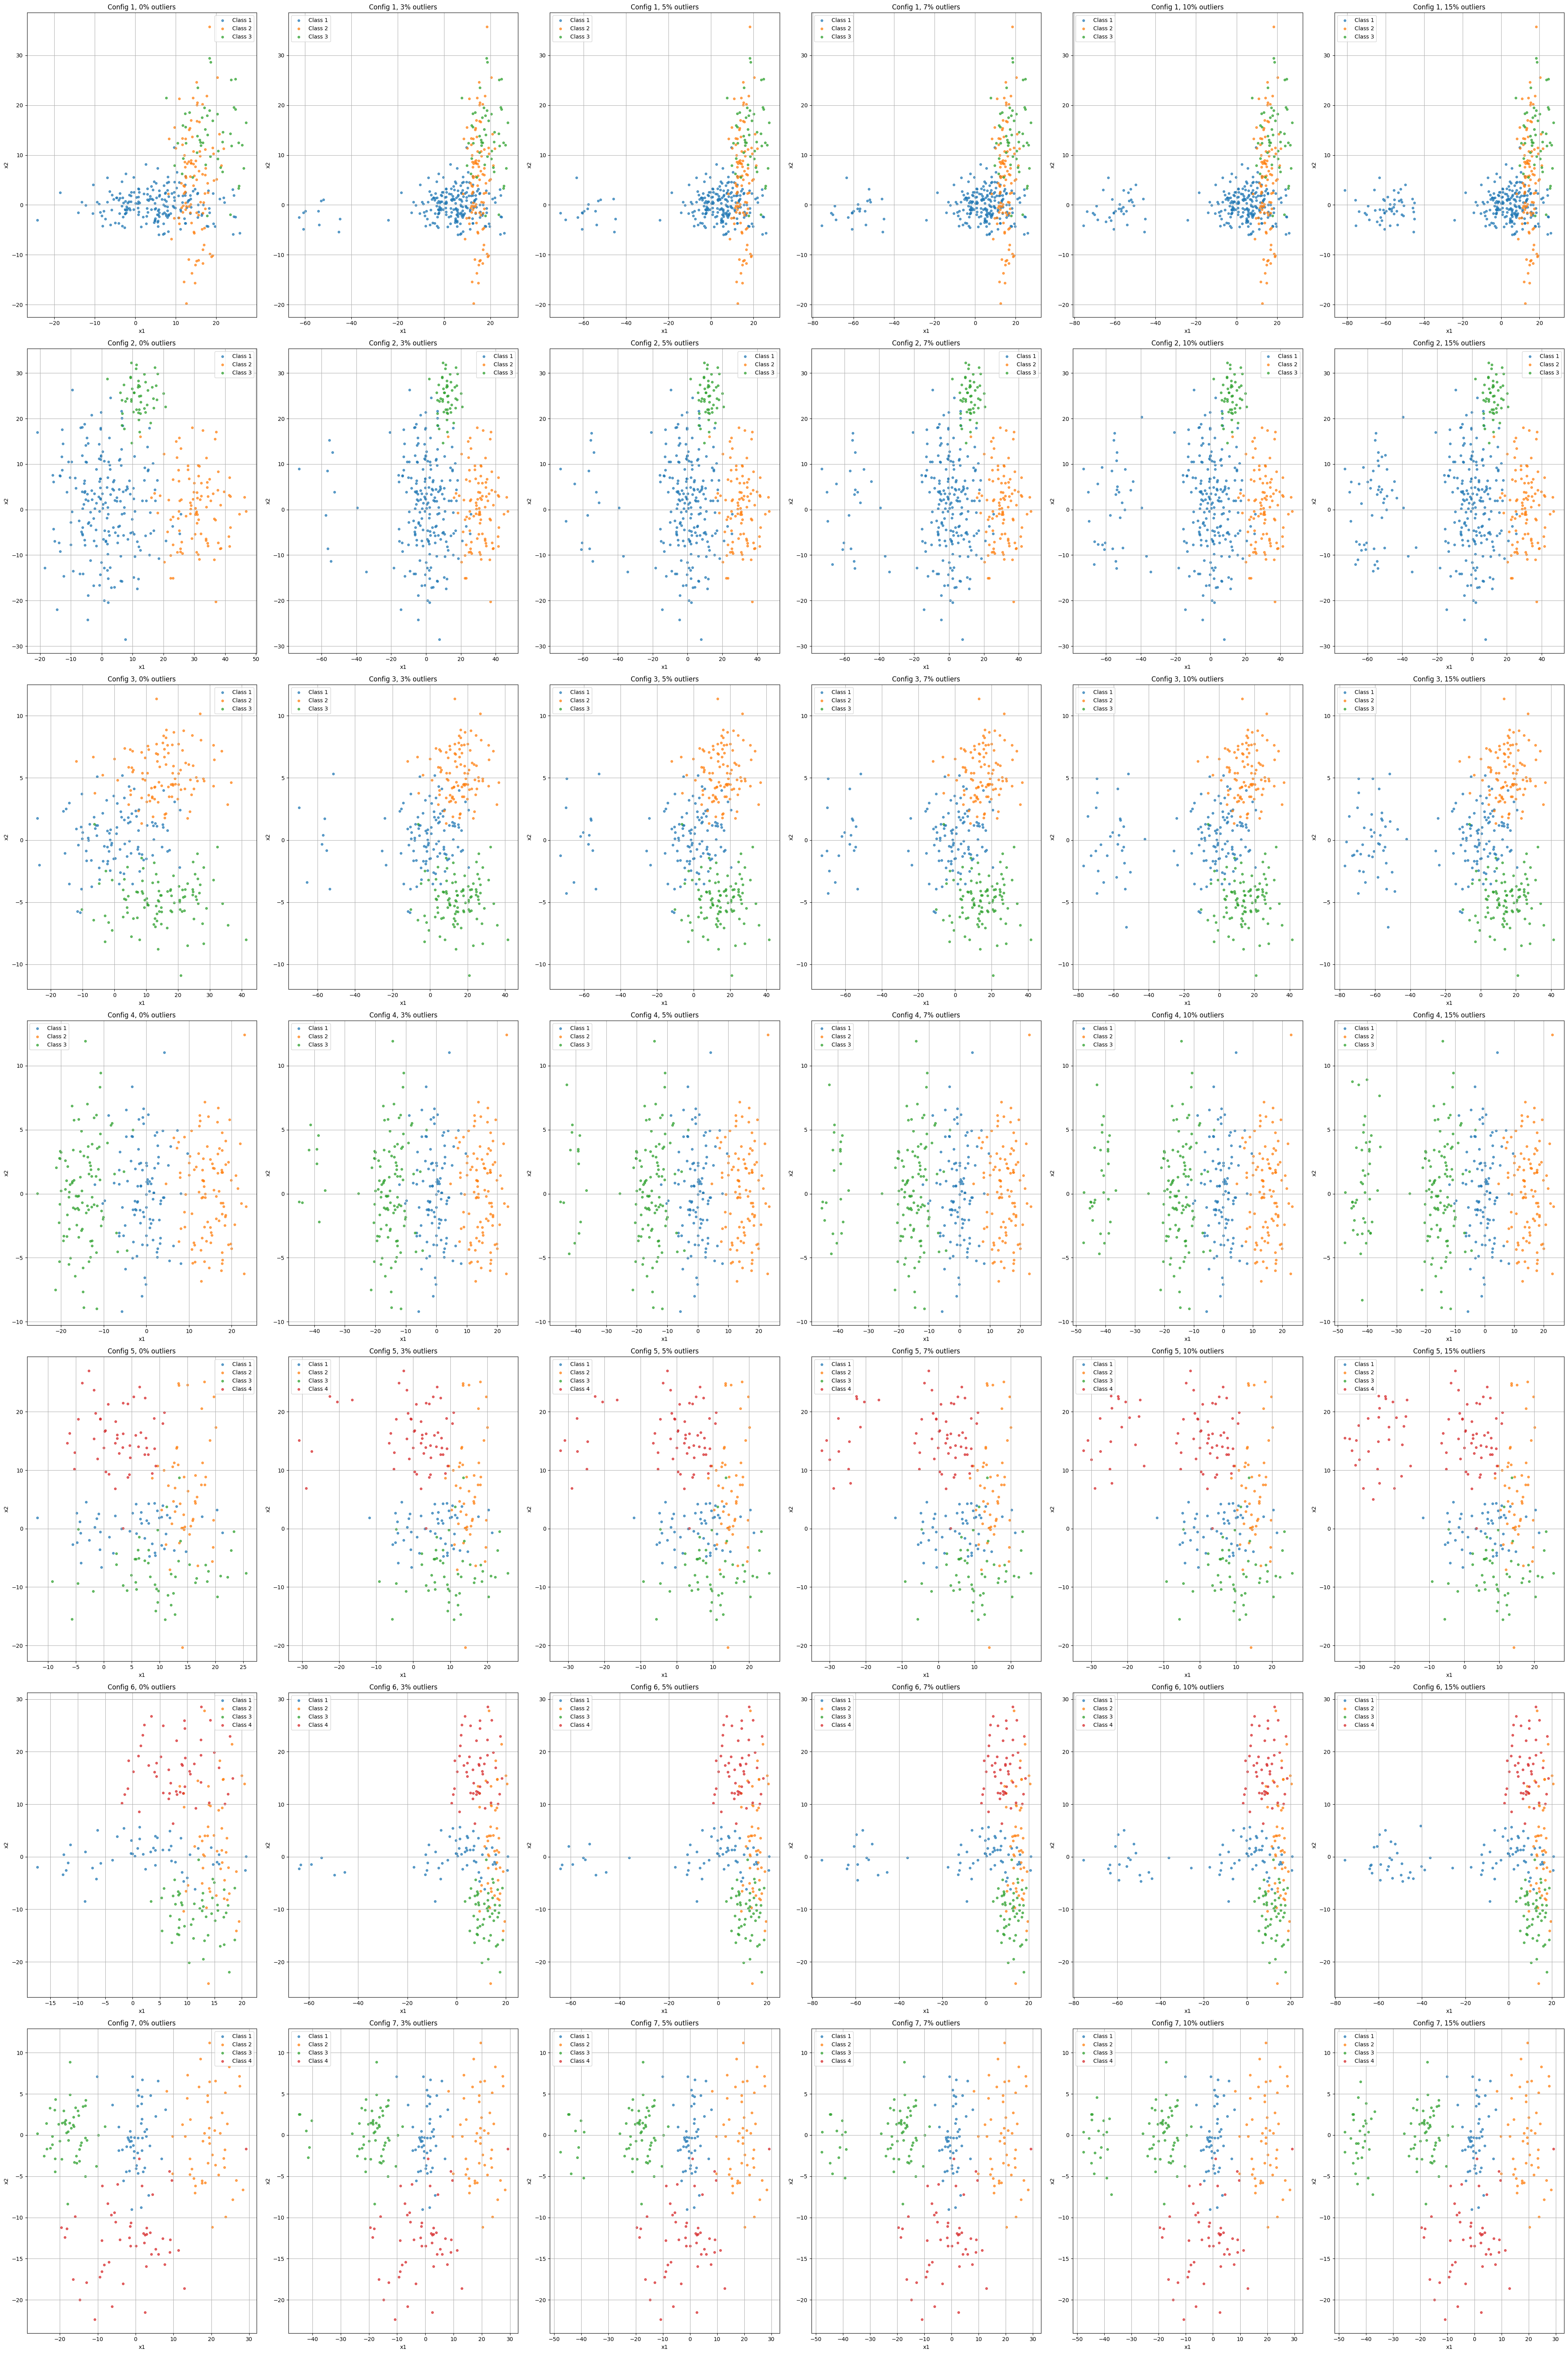

In [11]:
def adicionar_N_outliers_laterais(df_para_modificar: pd.DataFrame,
                                  df_original_referencia: pd.DataFrame,
                                  n_outliers_para_adicionar: int,
                                  cluster_id_alvo: int,
                                  multiplicador_std: float = 3.0) -> pd.DataFrame:
    
    if n_outliers_para_adicionar <= 0:
        return df_para_modificar.copy()
    
    dados_cluster_ref = df_original_referencia[df_original_referencia['class'] == cluster_id_alvo]
    
    std_x1_cluster = dados_cluster_ref['x1'].std()
    distancia_calculada = multiplicador_std * std_x1_cluster
    min_x1_cluster = dados_cluster_ref['x1'].min()
    centro_x1_outliers = min_x1_cluster - distancia_calculada

    std_x2_cluster = dados_cluster_ref['x2'].std()
    media_x2_cluster = dados_cluster_ref['x2'].mean()

    # Gera apenas o número N de novos outliers
    outliers_x1 = np.random.normal(loc=centro_x1_outliers, scale=std_x1_cluster, size=n_outliers_para_adicionar)
    outliers_x2 = np.random.normal(loc=media_x2_cluster, scale=std_x2_cluster, size=n_outliers_para_adicionar)

    df_novos_outliers = pd.DataFrame({'x1': outliers_x1, 'x2': outliers_x2})
    df_novos_outliers['class'] = cluster_id_alvo
    
    config_val = df_original_referencia['config'].iloc[0]
    df_novos_outliers['config'] = config_val
    
    # Concatena os novos outliers ao dataframe que já está sendo modificado
    df_final = pd.concat([df_para_modificar, df_novos_outliers], ignore_index=True)
    
    return df_final

lista_dfs_originais = [df1, df2, df3, df4, df5, df6, df7]

# 3. NOVA LÓGICA CUMULATIVA PARA ADICIONAR OUTLIERS

configuracoes_meta = [
    {'config_id': 1, 'outlier_target_cluster': 1},
    {'config_id': 2, 'outlier_target_cluster': 1},
    {'config_id': 3, 'outlier_target_cluster': 1},
    {'config_id': 4, 'outlier_target_cluster': 3},
    {'config_id': 5, 'outlier_target_cluster': 4},
    {'config_id': 6, 'outlier_target_cluster': 1},
    {'config_id': 7, 'outlier_target_cluster': 3}
]

# Garante que as porcentagens estão em ordem crescente
porcentagens_outlier = sorted([0, 0.03, 0.05, 0.07, 0.1, 0.15])

datasets_outliers = {}

for config_meta in configuracoes_meta:
    config_id = config_meta['config_id']
    df_original = lista_dfs_originais[config_id - 1]
    
    n_pontos_original = len(df_original)
    
    # df_acumulado guarda o resultado da etapa anterior
    df_acumulado = df_original.copy()
    datasets_outliers[(config_id, 0.0)] = df_acumulado

    
    # Itera sobre as porcentagens para calcular quantos outliers adicionar a cada passo
    for i in range(1, len(porcentagens_outlier)):
        p_atual = porcentagens_outlier[i]
        p_anterior = porcentagens_outlier[i-1]
        
        # Calcula o número total de outliers que deveríamos ter neste passo
        n_outliers_alvo = int(n_pontos_original * p_atual)
        
        # Calcula quantos outliers já existem no dataframe acumulado
        n_outliers_existentes = len(df_acumulado) - n_pontos_original
        
        # A diferença é o número de novos outliers a adicionar
        n_para_adicionar = n_outliers_alvo - n_outliers_existentes

        # Adiciona o número calculado de outliers ao dataframe já modificado
        df_acumulado = adicionar_N_outliers_laterais(
            df_para_modificar=df_acumulado,
            df_original_referencia=df_original, # Importante usar o original como referência
            n_outliers_para_adicionar=n_para_adicionar,
            cluster_id_alvo=config_meta['outlier_target_cluster'],
            multiplicador_std=4.0
        )
        datasets_outliers[(config_id, p_atual)] = df_acumulado


num_configs = len(configuracoes_meta)
num_outlier_porc = len(porcentagens_outlier)

fig, axes = plt.subplots(num_configs, num_outlier_porc, figsize=(40, 60), squeeze=False)

for i, config_meta in enumerate(configuracoes_meta):
    for j, percent_outliers in enumerate(porcentagens_outlier):
        ax = axes[i, j]
        config_id = config_meta['config_id']
        
        df_to_plot = datasets_outliers.get((config_id, percent_outliers))

        if df_to_plot is not None:
            for classe, dados_classe in df_to_plot.groupby('class'):
                ax.scatter(dados_classe['x1'], dados_classe['x2'], label=f'Class {classe}', s=15, alpha=0.7)
            
            ax.set_title(f'Config {config_id}, {int(percent_outliers*100)}% outliers')
            ax.set_xlabel('x1')
            ax.set_ylabel('x2')
            ax.legend()
            ax.grid(True)

plt.tight_layout()
plt.show()

In [12]:
np.random.seed(42)

for config in range(1, num_configs + 1):
    for outlier in porcentagens_outlier:
        df = datasets_outliers.get((config, outlier)).copy()
        #print(df)
        df.drop("config", axis=1, inplace=True) 
        
        labels = df["class"].values
        num_clusters = len(df['class'].unique())
        
        df.drop("class", axis=1, inplace=True)
        
        dados = df.to_numpy()
        
        media_indice_rand, dp_indice_rand = monte_carlo_fuzzy_simulation(dados, labels, num_clusters)
        print("-" * 30)
        print(f"Configuração: {config}, Outlier: {int(outlier * 100)}%")
        print(f"Mean Rand Index: {media_indice_rand:.3f}")
        print(f"Standard Deviation of Rand Index: {dp_indice_rand:.3f}")

------------------------------
Configuração: 1, Outlier: 0%
Mean Rand Index: 0.271
Standard Deviation of Rand Index: 0.050
------------------------------
Configuração: 1, Outlier: 3%
Mean Rand Index: 0.268
Standard Deviation of Rand Index: 0.053
------------------------------
Configuração: 1, Outlier: 5%
Mean Rand Index: 0.282
Standard Deviation of Rand Index: 0.036
------------------------------
Configuração: 1, Outlier: 7%
Mean Rand Index: 0.267
Standard Deviation of Rand Index: 0.061
------------------------------
Configuração: 1, Outlier: 10%
Mean Rand Index: 0.248
Standard Deviation of Rand Index: 0.094
------------------------------
Configuração: 1, Outlier: 15%
Mean Rand Index: 0.232
Standard Deviation of Rand Index: 0.106
------------------------------
Configuração: 2, Outlier: 0%
Mean Rand Index: 0.603
Standard Deviation of Rand Index: 0.123
------------------------------
Configuração: 2, Outlier: 3%
Mean Rand Index: 0.584
Standard Deviation of Rand Index: 0.133
--------------